In [1]:
# imports

from nemo.collections.tts.models import FlowtronModel
# from nemo.collections.tts.models import WaveGlowModel
from nemo.collections.tts.models import HifiGanModel
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import torch
import os
from scipy.io.wavfile import write

NOTE! Installing ujson may make loading annotations faster.


################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-02-15 21:55:21 experimental:27] Module <function get_argmin_mat at 0x7fd5ce0f0af0> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-02-15 21:55:21 experimental:27] Module <function getMultiScaleCosAffinityMatrix at 0x7fd5ce25d3a0> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-02-15 21:55:21 experimental:27] Module <function parse_scale_configs at 0x7fd5ce0fa4c0> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022

In [2]:
# set parameters

# flowtron_path="/akshita/NeMo/tutorials/tts/nemo_experiments/FlowtronNGC/Flowtrone649.nemo"
# ext="nemo"
flowtron_path="/akshita/NeMo/tutorials/tts/nemo_experiments/FlowtronNGCattnpriors2_904/Flowtron--val_loss=-1.0509-epoch=207.ckpt"
outputdir="/akshita/NeMo/tutorials/tts/nemo_experiments/FlowtronNGCattnpriors2_904/"
ext="ckpt"
# waveglow_pretrained_model="tts_waveglow_268m"
hifigan_pretrained_model="tts_hifigan"
text_input="It is well known that deep generative models have rich latent space"
speaker_id=0
sigma=0.5
sampling_rate=22050
seed=1234

In [3]:
# loading the models

if ext=="nemo":
    spec_gen_model = FlowtronModel.restore_from(restore_path=flowtron_path).eval().cuda()
else:
    spec_gen_model = FlowtronModel.load_from_checkpoint(checkpoint_path=flowtron_path).eval().cuda()
# vocoder_model = WaveGlowModel.from_pretrained(waveglow_pretrained_model, strict=False).eval().cuda()
vocoder_model = HifiGanModel.from_pretrained(hifigan_pretrained_model, strict=False).eval().cuda()

[NeMo W 2022-02-15 21:55:22 modelPT:135] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.FlowtronData
      manifest_filepath: /akshita/flowtron/filelists/ljs_audiopaths_text_sid_train_filelist.txt
      filter_length: 1024
      hop_length: 256
      win_length: 1024
      sampling_rate: 22050
      mel_fmin: 0.0
      mel_fmax: 8000.0
      n_frames_per_step: 1
      max_wav_value: 32768.0
      p_arpabet: 0.5
      cmudict_path: /akshita/flowtron/data/cmudict_dictionary
      text_cleaners:
      - flowtron_cleaners
      speaker_ids: null
      use_attn_prior: false
      attn_prior_threshold: 0.0
      prior_cache_path: /akshita/attention_prior_cache
      betab_scaling_factor: 1.0
      keep_ambiguous: false
      seed:
        model.seed: null
      randomize: true
    datalo

[NeMo I 2022-02-15 21:55:27 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.6.0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2022-02-15 21:55:27 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.6.0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2022-02-15 21:55:27 common:729] Instantiating model from pre-trained checkpoint


[NeMo W 2022-02-15 21:55:30 modelPT:135] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-02-15 21:55:30 modelPT:142] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-02-15 21:55:30 features:264] PADDING: 0
[NeMo I 2022-02-15 21:55:30 features:281] STFT using torch


[NeMo W 2022-02-15 21:55:31 features:241] Using torch_stft is deprecated and will be removed in 1.1.0. Please set stft_conv and stft_exact_pad to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-02-15 21:55:31 features:264] PADDING: 0
[NeMo I 2022-02-15 21:55:31 features:281] STFT using torch
[NeMo I 2022-02-15 21:55:32 save_restore_connector:154] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.6.0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


In [4]:
# run inference

with torch.no_grad():
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False
    parsed = spec_gen_model.parse(text_input, speaker_id=speaker_id)
    spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, n_frames=400, sigma=sigma)
    print(spectrogram.size()) # debug
#     audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram, sigma=0.8, denoise=True)
    audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)

spectrogram = spectrogram.to('cpu').numpy()[0]
audio = audio.to('cpu').numpy()[0]
audio = audio / np.abs(audio).max()

Number of speakers : 1
Number of speakers : 1
Hitting gate limit
torch.Size([1, 80, 360])


In [5]:
# listen to the audio

ipd.Audio(audio, rate=22050)

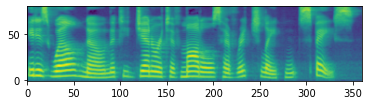

In [6]:
%matplotlib inline

# visualize the spectrogram

if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()

In [ ]:
# write(os.path.join(outputdir, 'waveglow_sid{}_sigma{}.wav'.format(speaker_id, sigma)), sampling_rate, audio)

write(os.path.join(outputdir, 'hifigan_sid{}.wav'.format(speaker_id, sigma)), sampling_rate, audio)